# **Predicción del Movimiento de Nubes para la Optimización de Plantas Fotovoltaicas en Colombia**

## 1) Descarga de imágenes

A continuación se muestra el código empleado para la descarga de imágenes correspondientes a la banda 13 para el periodo de tiempo comprendido entre el 01/01/2024 y el 31/12/2024. Ingresar al siguiente repositorio de github: https://github.com/alwos19/monografia_esp_cd

## 2) Obtención del dataset

A partir de las imagenes obtenidas se realiza la construcción de una dataset en el que las columnas correspondan a cada hora del día y las filas a cada día del año, dentro de cada celda se ubica la imagen correspondiente con una tamaño de 920X920, el valor de cada pixel corresponde a los valores de radiancia para le día y la hora correspondientes.

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

# Ruta donde están almacenados los archivos .npy
ruta_archivos = "./rad13"  # Cambia esto por la ruta real

# Función para procesar un archivo individual
def procesar_archivo(archivo):
    if archivo.endswith(".npy") and archivo.startswith("RadFC_"):
        # Extraer la parte de fecha y hora del nombre del archivo
        try:
            nombre = archivo.replace("RadFC_", "").replace("_Rad13.npy", "")
            fecha_str = nombre[:12]  # 'YYYYMMDDHHMM'
            fecha_datetime = datetime.strptime(fecha_str, "%Y%m%d%H%M")
            hora = fecha_datetime.strftime("%H:%M")

            # Cargar los valores de radiancia
            ruta_completa = os.path.join(ruta_archivos, archivo)
            radiancia = np.load(ruta_completa)

            # Validar que la dimensión sea 920 x 920
            if radiancia.shape == (920, 920):
                return {
                    "fecha": fecha_datetime,
                    "hora": hora,
                    "radiancia": radiancia
                }
            else:
                print(f"Dimensiones incorrectas en: {archivo}")
        except ValueError:
            print(f"Formato de fecha inválido en: {archivo}")
    return None

# Procesar archivos en paralelo
def procesar_archivos_en_paralelo(ruta_archivos):
    archivos = os.listdir(ruta_archivos)
    datos = []
    with ProcessPoolExecutor() as executor:
        resultados = executor.map(procesar_archivo, archivos)
        for resultado in resultados:
            if resultado is not None:
                datos.append(resultado)
    return datos

# Ejecutar el procesamiento
datos = procesar_archivos_en_paralelo(ruta_archivos)

# Crear el DataFrame
df_imagenes = pd.DataFrame(datos)

# Mostrar primeras filas
print(df_imagenes.head())

                fecha   hora  \
0 2024-08-07 00:00:00  00:00   
1 2024-10-09 14:00:00  14:00   
2 2024-05-30 08:00:00  08:00   
3 2024-05-10 11:00:00  11:00   
4 2024-10-28 14:00:00  14:00   

                                           radiancia  
0  [[29.954382, 29.862925, 29.268448, 28.536785, ...  
1  [[94.3407, 91.96279, 93.10602, 94.9809, 95.529...  
2  [[30.00011, 32.469475, 35.30467, 37.31674, 37....  
3  [[89.81354, 82.77128, 76.96371, 72.2079, 59.81...  
4  [[96.99297, 97.084435, 96.81006, 95.34673, 93....  


IndexError: index 24 is out of bounds for axis 0 with size 24

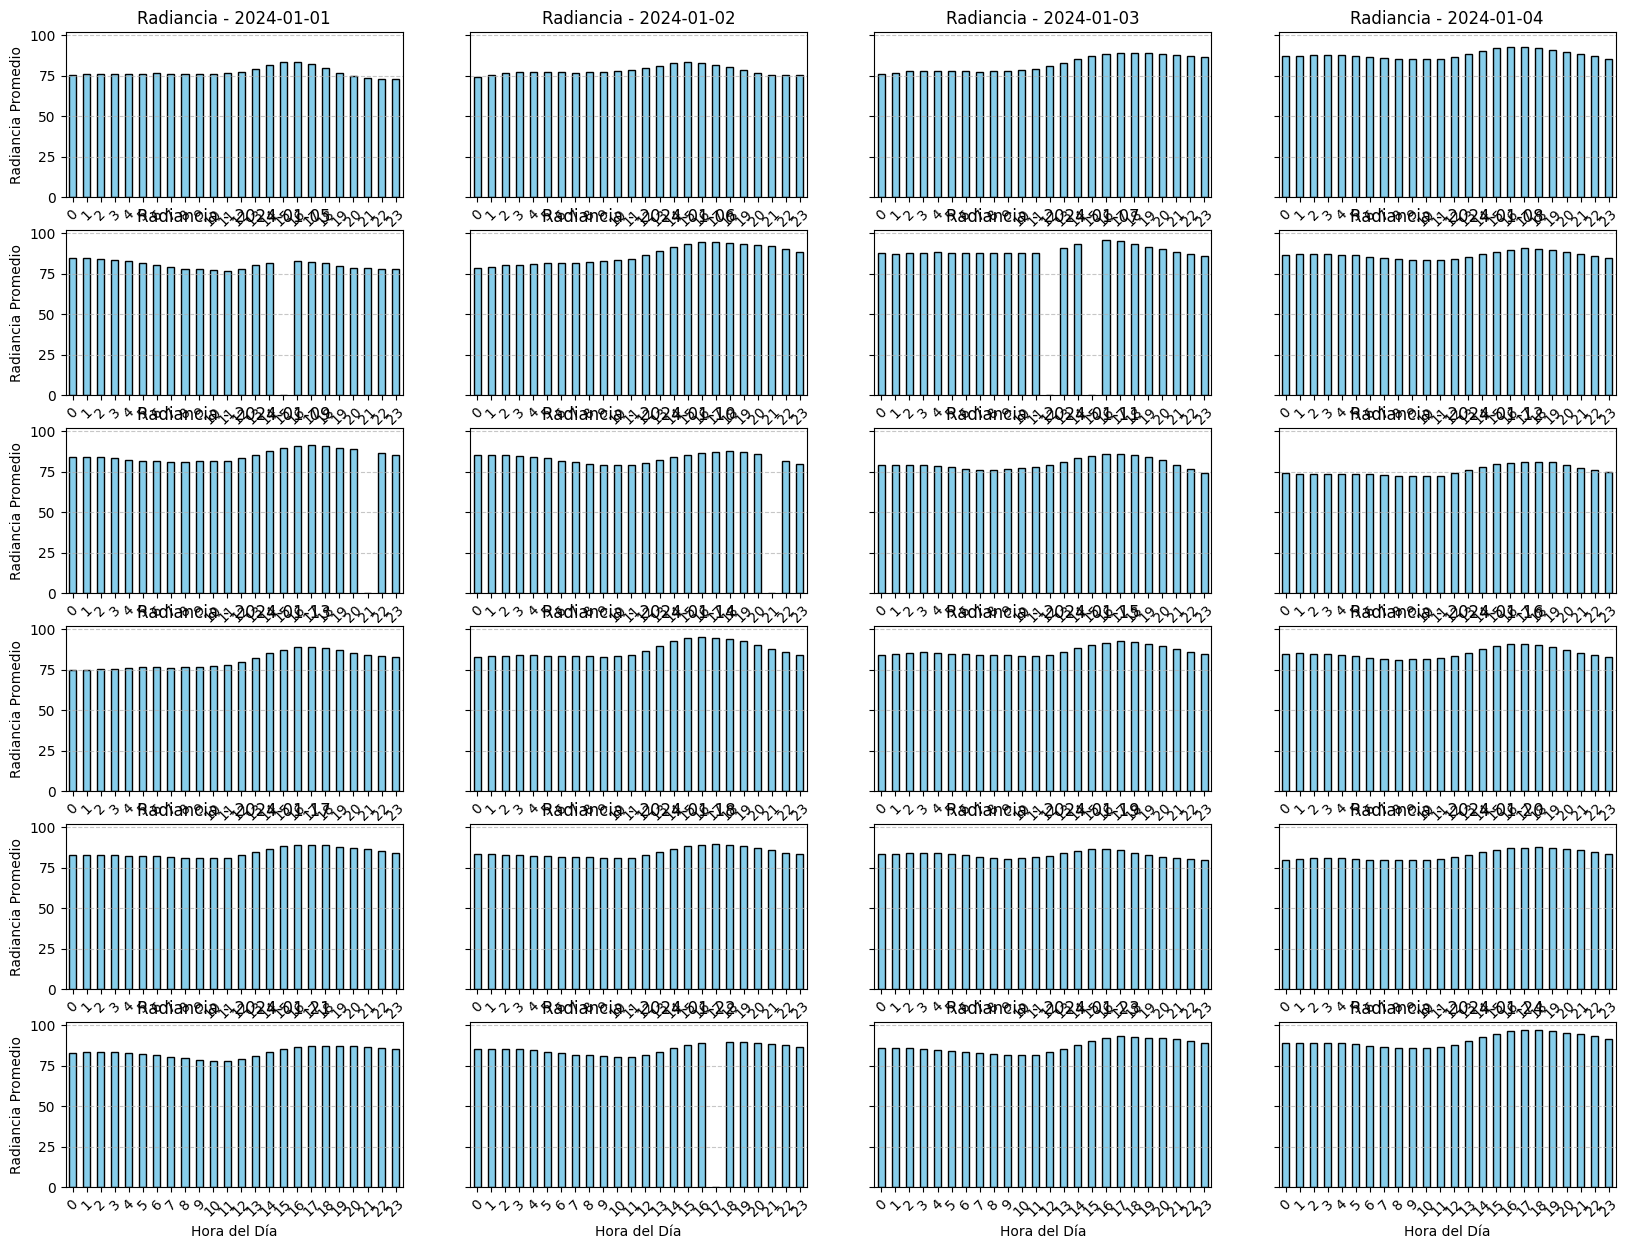

In [23]:
# Crear una columna con solo la fecha (sin hora)
df_imagenes['fecha_sin_hora'] = df_imagenes['fecha'].dt.date

# Agrupar por fecha y hora, y calcular el promedio de radiancia
promedio_por_dia_hora = df_imagenes.groupby(['fecha_sin_hora', df_imagenes['fecha'].dt.hour])['radiancia_promedio'].mean().unstack()

# Configurar el tamaño de la figura
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 15), sharey=True)
axes = axes.flatten()

# Graficar cada día en un subplot
for i, (dia, valores) in enumerate(promedio_por_dia_hora.iterrows()):
    ax = axes[i]
    valores.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f"Radiancia - {dia}")
    ax.set_xlabel("Hora del Día")
    ax.set_ylabel("Radiancia Promedio")
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels(range(0, 24), rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el diseño
plt.tight_layout()
plt.show()

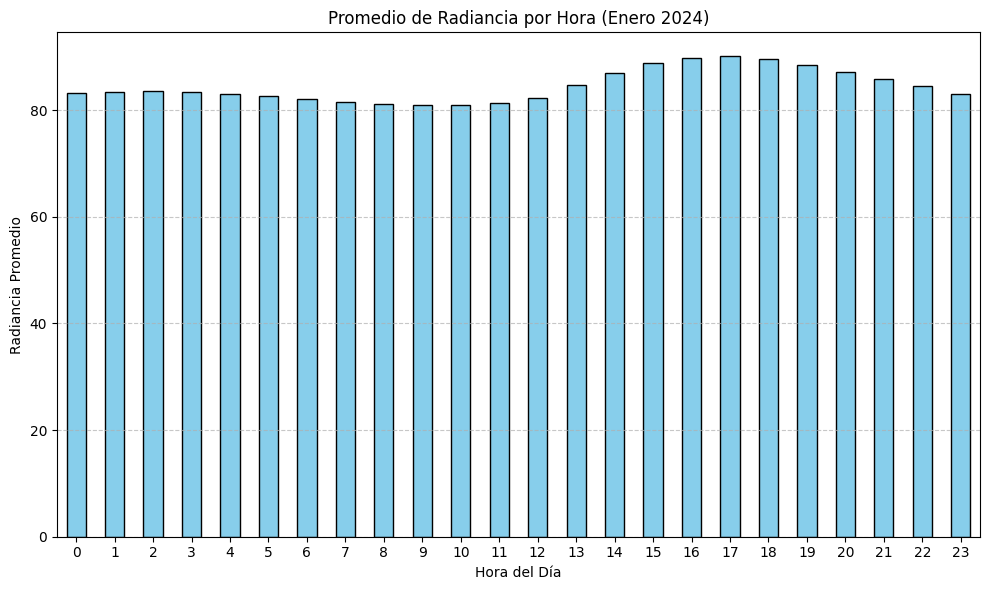

In [22]:
# Calcular el promedio de radiancia por hora para enero
promedio_por_hora_enero = df_enero.groupby(df_enero['fecha'].dt.hour)['radiancia_promedio'].mean()

# Graficar el promedio de radiancia por hora para enero
plt.figure(figsize=(10, 6))
promedio_por_hora_enero.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Promedio de Radiancia por Hora (Enero 2024)")
plt.xlabel("Hora del Día")
plt.ylabel("Radiancia Promedio")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

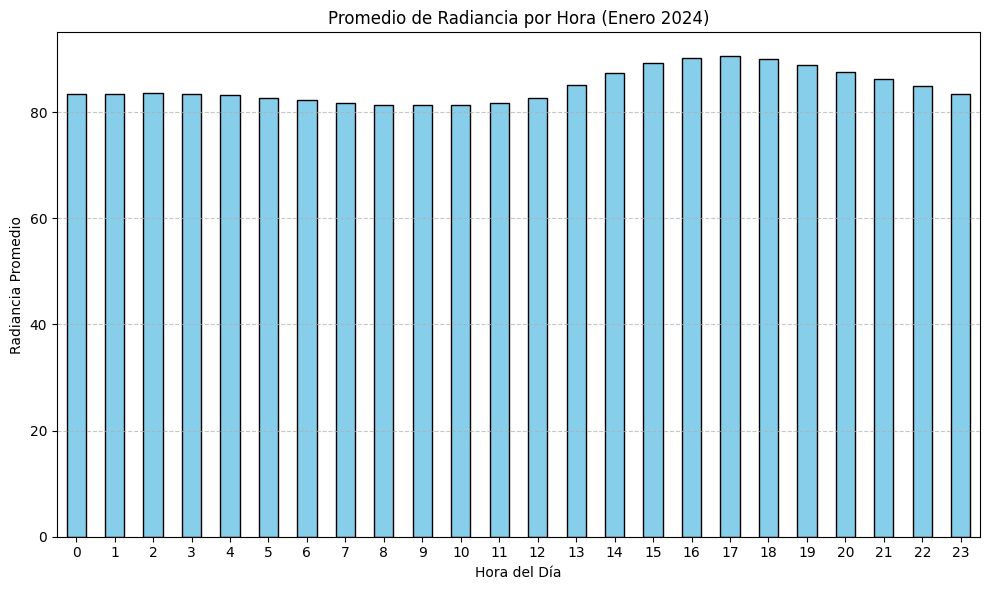

In [21]:
# Filtrar las fechas entre 2024-01-01 y 2024-01-30
fecha_inicio = pd.Timestamp('2024-01-01')
fecha_fin = pd.Timestamp('2024-01-30')
df_filtrado = df_imagenes[(df_imagenes['fecha'] >= fecha_inicio) & (df_imagenes['fecha'] <= fecha_fin)]

# Calcular el promedio de radiancia por hora
promedio_por_hora = df_filtrado.groupby(df_filtrado['fecha'].dt.hour)['radiancia_promedio'].mean()

# Graficar el promedio de radiancia por hora
plt.figure(figsize=(10, 6))
promedio_por_hora.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Promedio de Radiancia por Hora (Enero 2024)")
plt.xlabel("Hora del Día")
plt.ylabel("Radiancia Promedio")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Filtrar las fechas entre 2024-01-01 y 2024-02-28
fecha_inicio = pd.Timestamp('2024-01-01')
fecha_fin = pd.Timestamp('2024-02-28')
df_filtrado = df_imagenes[(df_imagenes['fecha'] >= fecha_inicio) & (df_imagenes['fecha'] <= fecha_fin)]

# Calcular el promedio de radiancia por hora
promedio_por_hora = df_filtrado.groupby(df_filtrado['fecha'].dt.hour)['radiancia_promedio'].mean()

# Graficar el promedio de radiancia por hora
plt.figure(figsize=(10, 6))
promedio_por_hora.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Promedio de Radiancia por Hora (Enero-Febrero 2024)")
plt.xlabel("Hora del Día")
plt.ylabel("Radiancia Promedio")
plt.xticks(rotation=0)
plt.grid(axis='# Graficar el promedio de radiancia por hora
plt.figure(figsize=(10, 6))
promedio_por_hora.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Promedio de Radiancia por Hora (Enero-Febrero 2024)")
plt.xlabel("Hora del Día")
plt.ylabel("Radiancia Promedio")
plt.xticks(rotation=0)
plt.grid(axis='

# Mostrar los resultados
print(promedio_por_hora)

fecha
0     80.210907
1     80.303154
2     80.439186
3     80.401031
4     80.218964
5     79.810822
6     79.353584
7     78.953568
8     78.827507
9     78.868576
10    79.110207
11    79.440094
12    80.524757
13    82.774559
14    84.945129
15    87.114090
16    87.805435
17    88.029686
18    87.471123
19    86.242561
20    84.770370
21    83.177963
22    81.806023
23    80.372475
Name: radiancia_promedio, dtype: float32


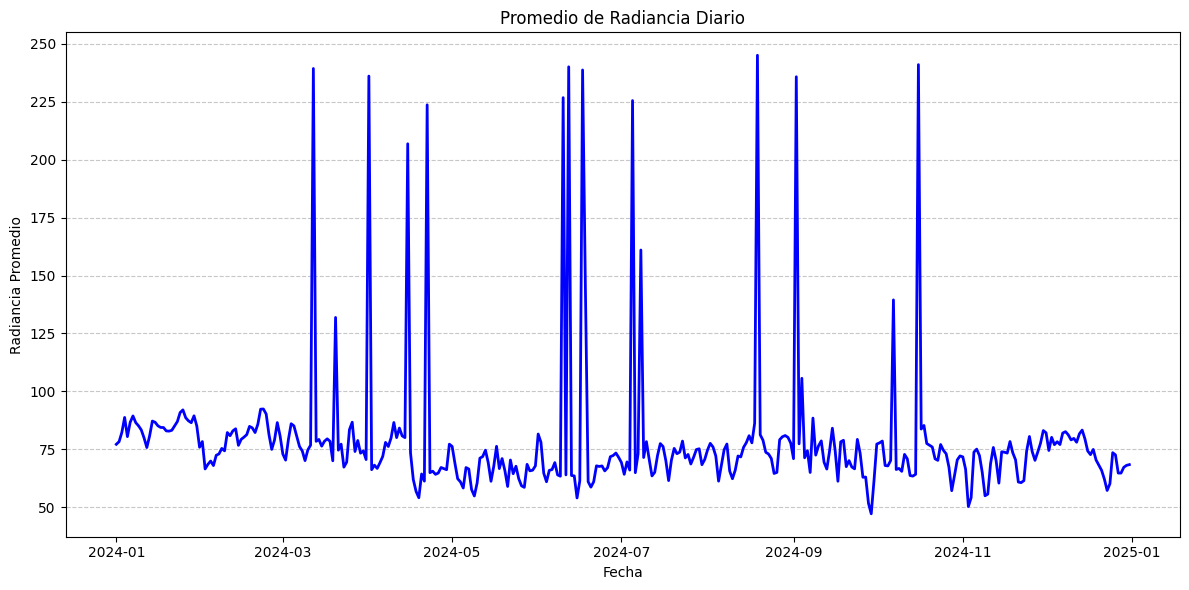

In [16]:
# Agregar una columna con solo la fecha (sin hora)
df_imagenes['fecha_sin_hora'] = df_imagenes['fecha'].dt.date

# Calcular el promedio de radiancia por día
promedio_diario = df_imagenes.groupby('fecha_sin_hora')['radiancia_promedio'].mean()

# Graficar el promedio diario
plt.figure(figsize=(12, 6))
promedio_diario.plot(color='blue', linewidth=2)
plt.title("Promedio de Radiancia Diario")
plt.xlabel("Fecha")
plt.ylabel("Radiancia Promedio")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
df_imagenes.head(2)

,fecha,hora,radiancia,radiancia_promedio,mes,fecha_sin_hora
0,2024-08-07 00:00:00,00:00,"[[29.954382, 29.862925, 29.268448, 28.536785, ...",72.127602,8,2024-08-07
1,2024-10-09 14:00:00,14:00,"[[94.3407, 91.96279, 93.10602, 94.9809, 95.529...",74.974686,10,2024-10-09


In [15]:
# Fechas procesadas
fechas_procesadas = set(df_imagenes['fecha'])

# Fechas faltantes
fechas_faltantes = set(rango_fechas) - fechas_procesadas

# Mostrar resultados
print(f"Total de fechas procesadas: {len(fechas_procesadas)}")
print(f"Total de fechas faltantes: {len(fechas_faltantes)}")

Total de fechas procesadas: 8744
Total de fechas faltantes: 61


In [ ]:
# Calcular el promedio de radiancia por día
promedio_diario = df_imagenes.groupby('fecha_sin_hora')['radiancia_promedio'].mean()

# Graficar el promedio diario
plt.figure(figsize=(12, 6))
promedio_diario.plot(color='blue', linewidth=2)
plt.axhline(media_global, color='red', linestyle='--', linewidth=2, label=f"Media Global = {media_global:.2f}")
plt.title("Promedio de Radiancia Diario")
plt.xlabel("Fecha")
plt.ylabel("Radiancia Promedio")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Agregar una columna con solo la fecha (sin hora)
df_imagenes['fecha_sin_hora'] = df_imagenes['fecha'].dt.date

# Calcular el promedio de radiancia por día
promedio_diario = df_imagenes.groupby('fecha_sin_hora')['radiancia_promedio'].mean()

# Mostrar los primeros resultados
print(promedio_diario.head())

fecha_sin_hora
2024-01-01    77.209206
2024-01-02    78.325569
2024-01-03    82.345497
2024-01-04    88.789871
2024-01-05    80.505081
Name: radiancia_promedio, dtype: float32


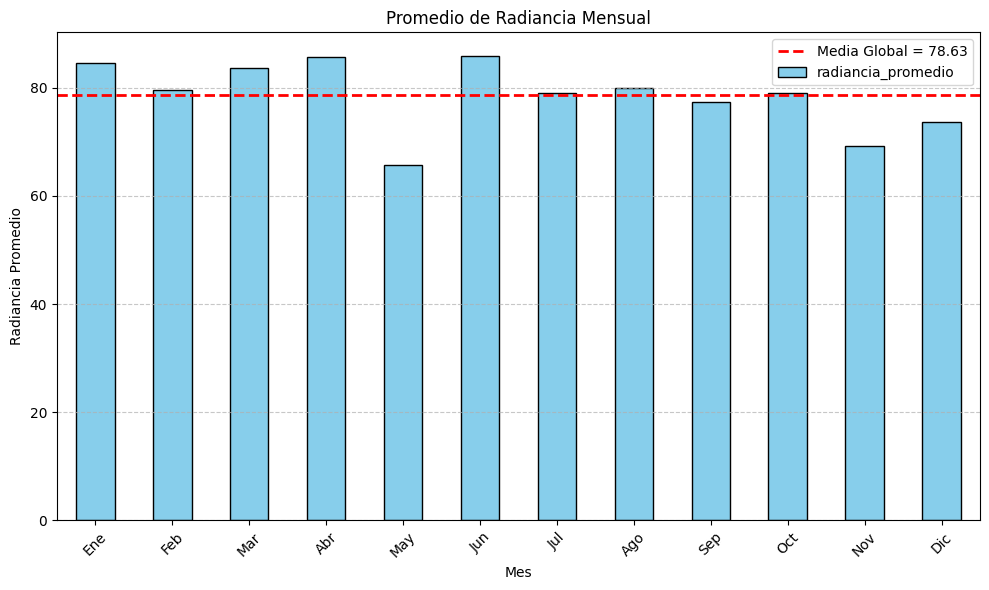

In [12]:
# Calcular el promedio de radiancia por mes
df_imagenes['mes'] = df_imagenes['fecha'].dt.month
promedio_mensual = df_imagenes.groupby('mes')['radiancia_promedio'].mean()

# Graficar el promedio mensual
plt.figure(figsize=(10, 6))
promedio_mensual.plot(kind='bar', color='skyblue', edgecolor='black')
plt.axhline(media_global, color='red', linestyle='--', linewidth=2, label=f"Media Global = {media_global:.2f}")
plt.title("Promedio de Radiancia Mensual")
plt.xlabel("Mes")
plt.ylabel("Radiancia Promedio")
plt.xticks(ticks=range(12), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
# Identificar archivos que no se procesaron correctamente
archivos_totales = os.listdir(ruta_archivos)

# Extraer los nombres de los archivos procesados directamente
archivos_procesados = [os.path.basename(archivo) for archivo in archivos_totales if procesar_archivo(archivo) is not None]

# Calcular los archivos faltantes
archivos_faltantes = set(archivos_totales) - set(archivos_procesados)

# Mostrar información
print(f"Total de archivos en la carpeta: {len(archivos_totales)}")
print(f"Total de archivos procesados: {len(archivos_procesados)}")
print(f"Total de archivos faltantes: {len(archivos_faltantes)}")

# Mostrar los archivos faltantes
if archivos_faltantes:
    print("Archivos faltantes:")
    for archivo in archivos_faltantes:
        print(archivo)
else:
    print("No hay archivos faltantes.")

KeyboardInterrupt: 

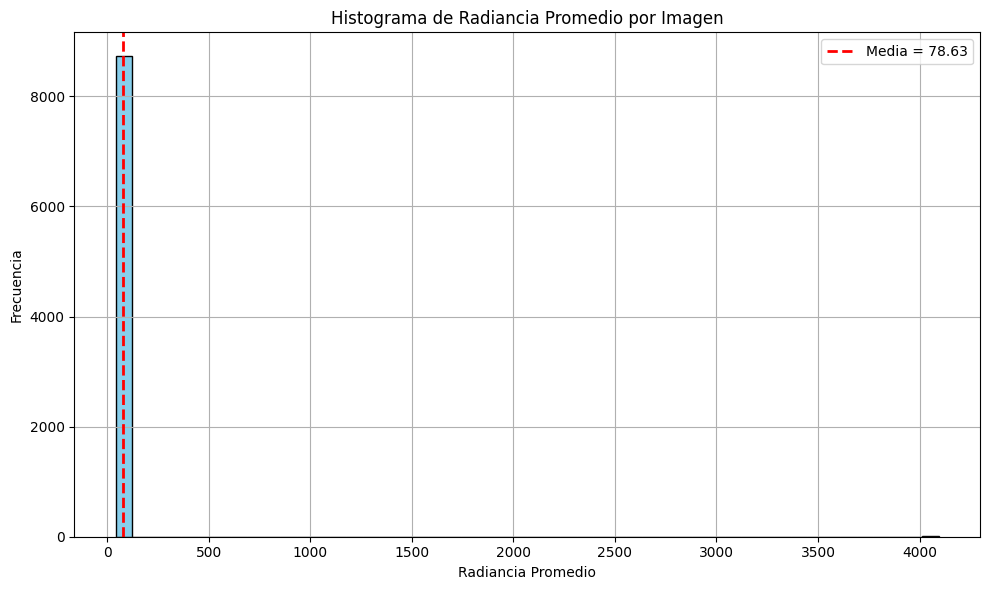

In [10]:
# Calcular el promedio de radiancia para cada imagen
df_imagenes["radiancia_promedio"] = df_imagenes["radiancia"].apply(np.mean)

# Verificar número de registros
assert len(df_imagenes) == 8744, "La cantidad de registros no es 6002."

# Calcular la media global de los promedios de radiancia
media_global = df_imagenes["radiancia_promedio"].mean()

# Graficar el histograma
plt.figure(figsize=(10, 6))
plt.hist(df_imagenes["radiancia_promedio"], bins=50, color='skyblue', edgecolor='black')
plt.axvline(media_global, color='red', linestyle='--', linewidth=2, label=f"Media = {media_global:.2f}")
plt.title("Histograma de Radiancia Promedio por Imagen")
plt.xlabel("Radiancia Promedio")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df_imagenes['fecha'] = pd.to_datetime(df_imagenes['fecha'])

In [6]:
df_imagenes

,fecha,hora,radiancia
0,2024-01-01 02:00:00,02:00,"[[98.684944, 98.82213, 98.684944, 98.86786, 98..."
1,2024-01-01 00:00:00,00:00,"[[97.861824, 97.67891, 97.22162, 97.084435, 97..."
2,2024-01-01 03:00:00,03:00,"[[97.99901, 98.41057, 98.684944, 98.776405, 98..."
3,2024-01-01 01:00:00,01:00,"[[94.24924, 98.776405, 99.27942, 99.23369, 99...."
4,2024-01-01 04:00:00,04:00,"[[99.096504, 98.95932, 98.684944, 98.59348, 98..."
5,2024-01-01 05:00:00,05:00,"[[98.273384, 97.99901, 98.684944, 99.32515, 99..."
